# 集成学习 - 梯度提升树GBDT（B站公开课课件）

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import seaborn as sns
import re, pip, conda
import time
import os

In [3]:
for package in [sklearn,mlp,np,pd,sns,pip,conda]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.0.1
matplotlib 3.4.3
numpy 1.21.4
pandas 1.3.4
seaborn 0.11.2
pip 21.3.1
conda 4.11.0


In [4]:
#pip install --upgrade scikit-learn
#conda update scikit-learn

目录

<font color=green>**【公开课】**</font>一 梯度提升树的基本思想<br>
<font color=green>**【公开课】**</font>&emsp;1 梯度提升树 pk AdaBoost<br>
<font color=green>**【公开课】**</font>&emsp;2 GradientBoosting回归与分类的实现<br>
<font color=green>**【公开课】**</font>二 梯度提升树的参数<br>
<font color=green>**【公开课】**</font>&emsp;1 迭代过程<br>
<font color=green>**【公开课】**</font>&emsp;&emsp; 1.1 初始预测结果$H_0$的设置<br>
<font color=red>**【完整版】**</font>&emsp;&emsp; 1.2 使用回归器完成分类任务<br>
<font color=green>**【公开课】**</font>&emsp;&emsp; 1.3 GBDT的8种损失函数<br>
<font color=red>**【完整版】**</font>&emsp;2 弱评估器结构<br>
<font color=red>**【完整版】**</font>&emsp;&emsp; 2.1 梯度提升树的弱评估器复杂度<br>
<font color=red>**【完整版】**</font>&emsp;&emsp; 2.2 弗里德曼均方误差<br>
<font color=red>**【完整版】**</font>&emsp;3 梯度提升树的提前停止机制<br>
<font color=red>**【完整版】**</font>&emsp;4 梯度提升树的袋外数据<br>
<font color=red>**【完整版】**</font>&emsp;5 缺失参数class_weight与n_jobs<br>
<font color=green>**【公开课】**</font>三 梯度提升树的参数空间与自动优化<br>
<font color=green>**【公开课】**</font>&emsp;1 GBDT的参数空间<br>
<font color=green>**【公开课】**</font>&emsp;2 基于TPE对GBDT进行优化<br>
<font color=red>**【完整版】**</font>四 原理进阶：梯度提升回归树的求解流程<br>
<font color=red>**【完整版】**</font>&emsp;1 GBDT的基本数学流程<br>
<font color=red>**【完整版】**</font>&emsp;2 初始化H0过程中的常数C是什么？<br>
<font color=red>**【完整版】**</font>&emsp;3 伪残差、残差与梯度有什么关系？<br>
<font color=red>**【完整版】**</font>&emsp;4 证明：拟合伪残差的合理性<br>

# 一 梯度提升树的基本思想

## 1 梯度提升树 pk AdaBoost

梯度提升树（Gradient Boosting Decision Tree，GBDT）是提升法中的代表性算法，它即是当代强力的XGBoost、LGBM等算法的基石，也是工业界应用最多、在实际场景中表现最稳定的机器学习算法之一。在最初被提出来时，GBDT被写作梯度提升机器（Gradient Boosting Machine，GBM），它融合了Bagging与Boosting的思想、扬长避短，可以接受各类弱评估器作为输入，在后来弱评估器基本被定义为决策树后，才慢慢改名叫做梯度提升树。受Boosting算法首个发扬光大之作AdaBoost的启发，GBDT中自然也包含Boosting三要素：

- 损失函数$L(x,y)$ ：用以衡量模型预测结果与真实结果的差异
- 弱评估器$f(x)$ ：（一般为）决策树，不同的boosting算法使用不同的建树过程
- 综合集成结果$H(x)$：即集成算法具体如何输出集成结果

同时，GBDT也遵循boosting算法的基本流程进行建模：

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{t-1}$的结果，计算损失函数$L(x,y)$，
    <br>并使用$L(x,y)$自适应地影响下一个弱评估器$f(x)_t$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_T$的影响。</center></font>**
---

但与AdaBoost不同的是，GBDT在整体建树过程中做出了以下几个关键的改变：

- **弱评估器**

> GBDT的弱评估器输出类型不再与整体集成算法输出类型一致。对于AdaBoost或随机森林算法来说，当集成算法执行的是回归任务时，弱评估器也是回归器，当集成算法执行分类任务时，弱评估器也是分类器。但对于GBDT而言，**无论GBDT整体在执行回归/分类/排序任务，弱评估器一定是回归器**。GBDT通过sigmoid或softmax函数输出具体的分类结果，但实际弱评估器一定是回归器。

<br>

- **损失函数$L(x,y)$**

> 在GBDT当中，损失函数范围不再局限于固定或单一的某个损失函数，而从数学原理上推广到了任意可微的函数。因此GBDT算法中可选的损失函数非常多，GBDT实际计算的数学过程也与损失函数的表达式无关。<br>

<br>

- **拟合残差**

> GBDT依然自适应调整弱评估器的构建，但却不像AdaBoost一样通过调整数据分布来**间接**影响后续弱评估器。相对的，GBDT通过修改后续弱评估器的拟合目标来直接影响后续弱评估器的结构。<br><br>
> 具体地来说，在AdaBoost当中，每次建立弱评估器之前需要修改样本权重，且用于建立弱评估器的是样本$X$以及对应的$y$，在GBDT当中，我们不修改样本权重，但每次用于建立弱评估器的是样本$X$以及当下集成输出$H(x_i)$与真实标签$y$的差异（$y - H(x_i)$）。这个差异在数学上被称之为残差（Residual），因此**GBDT不修改样本权重，而是通过拟合残差来影响后续弱评估器结构**。<br>

<br>

- **抽样思想**

> GBDT加入了随机森林中随机抽样的思想，在每次建树之前，允许对样本和特征进行抽样来增大弱评估器之间的独立性（也因此可以有袋外数据集）。虽然Boosting算法不会大规模地依赖于类似于Bagging的方式来降低方差，但由于Boosting算法的输出结果是弱评估器结果的加权求和，因此Boosting原则上也可以获得由“平均”带来的小方差红利。当弱评估器表现不太稳定时，采用与随机森林相似的方式可以进一步增加Boosting算法的稳定性。

<br>

除了以上四个改变之外，GBDT的求解流程与AdaBoost大致相同。因此，如果你对AdaBoost的流程相当熟悉，GBDT的建模过程并不难懂。sklearn当中集成了GBDT分类与GBDT回归，我们使用如下两个类来调用它们：

*class* `sklearn.ensemble.GradientBoostingClassifier`(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

*class* `sklearn.ensemble.GradientBoostingRegressor`(*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

比起AdaBoost，GBDT的超参数数量增加了不少，但与其他集成算法一样，GBDT回归器与GBDT分类器的超参数高度一致（实际上，对GBDT来说，是完全一致）。在课程当中，我们将重点介绍GBDT独有的参数，以及GBDT分类器与GBDT回归器中表现不一致的参数。

## 2 GradientBoosting的实现

In [5]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold

In [6]:
data = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\train_encode.csv",index_col=0)

In [7]:
data.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态,SalePrice
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0,208500
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0,181500
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0,223500
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,140000
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0,250000


In [8]:
#回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [9]:
X.shape

(1460, 80)

In [10]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [11]:
#定义所需的交叉验证方式
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

def RMSE(result,name):
    return abs(result[name].mean())

- 梯度提升回归树

In [43]:
gbr = GBR(random_state=1412) #实例化
result_gbdt = cross_validate(gbr,X,y,cv=cv
                             ,scoring="neg_root_mean_squared_error" #负根均方误差
                             ,return_train_score=True
                             ,verbose=True
                             ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [44]:
RMSE(result_gbdt,"train_score")

13990.790813889864

In [45]:
RMSE(result_gbdt,"test_score")

28783.954343252786

- 梯度提升回归与其他算法的对比

In [46]:
modelname = ["GBDT","RF","AdaBoost","RF-TPE","Ada-TPE"]

models = [GBR(random_state=1412)
         ,RFR(random_state=1412,n_jobs=-1)
         ,ABR(random_state=1412)
         ,RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0
              ,random_state=1412, verbose=False, n_jobs=-1)
         ,ABR(n_estimators=39, learning_rate=0.94,loss="exponential"
              ,random_state=1412)]

colors = ["green","gray","orange","red","blue"]

In [48]:
for name,model in zip(modelname,models):
    start = time.time()
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    end = time.time()-start
    print(name)
    print("\t train_score:{:.3f}".format(RMSE(result,"train_score")))
    print("\t test_score:{:.3f}".format(RMSE(result,"test_score")))
    print("\t time:{:.2f}s".format(end))
    print("\n")

GBDT
	 train_score:13990.791
	 test_score:28783.954
	 time:0.49s


RF
	 train_score:11177.272
	 test_score:30571.267
	 time:0.70s


AdaBoost
	 train_score:27062.107
	 test_score:35345.931
	 time:0.25s


RF-TPE
	 train_score:11208.818
	 test_score:28346.673
	 time:0.22s


Ada-TPE
	 train_score:27401.542
	 test_score:35169.730
	 time:0.23s




|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|0.7s|0.25s|0.49s|0.22s|0.23s|
|最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|

先来看默认参数下所有算法的表现。当不进行调参时，随机森林的运行时间最长、AdaBoost最快，GBDT居中，但考虑到AdaBoost的`n_estimators`参数的默认值为50，而GBDT和随机森林的`n_estimators`默认值都为100，可以认为AdaBoost的运行速度与GBDT相差不多。从结果来看，未调参状态下GBDT的结果是最好的，其结果甚至与经过TPE精密调参后的随机森林结果相差不多，而AdaBoost经过调参后没有太多改变，可以说AdaBoost极其缺乏调参空间、并且学习能力严重不足。

基于以上信息，我们可以观察三个算法的过拟合情况：

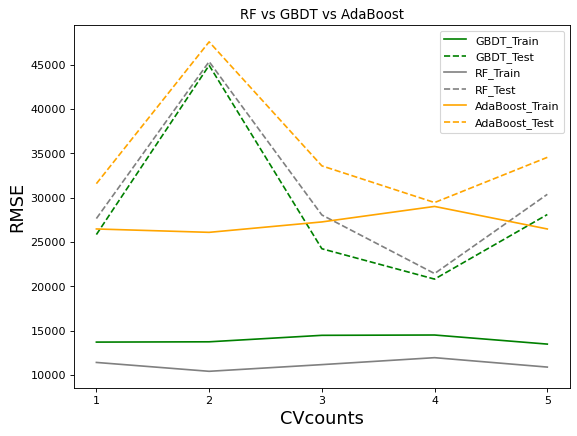

In [96]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[:3],models[:3],colors[:3]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("RF vs GBDT vs AdaBoost")
plt.legend()
plt.show()

不难发现，AdaBoost是过拟合程度最轻的，这也反映出它没有调参空间的事实，而GBDT与随机森林过拟合程度差不多，不过GBDT的过拟合程度相对较轻一些，这是因为**Boosting算法的原理决定了Boosting算法更加不容易过拟合**，这一点在后续讲解GBDT的参数时我们会详细说明。

我们可以绘制随机森林调参前后、以及AdaBoost调参前后的结果对比：

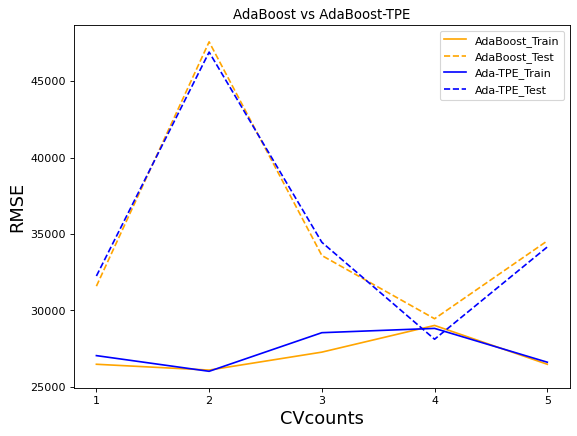

In [97]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[2:5:2],models[2:5:2],colors[2:5:2]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("AdaBoost vs AdaBoost-TPE")
plt.legend()
plt.show()

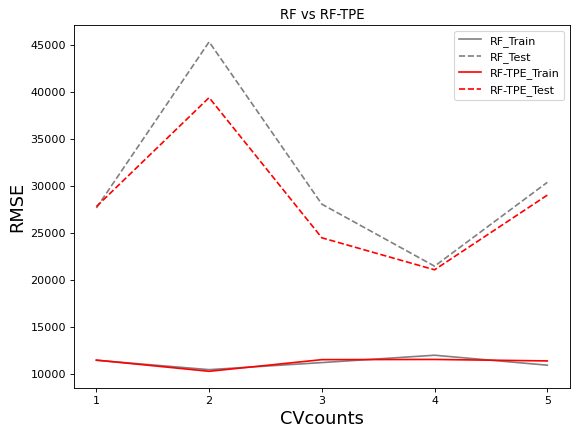

In [98]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[1:4:2],models[1:4:2],colors[1:4:2]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("RF vs RF-TPE")
plt.legend()
plt.show()

不难发现，AdaBoost在经过精密调参后，并没有太多改变，而随机森林调参后过拟合程度明显降低，测试集上的结果明显提升，这是随机森林在潜力和根本原则上都比AdaBoost要强大的表现。那GBDT的表现如何呢？GBDT在默认参数上的结果接近经过TPE调参后的随机森林，我们来看看这两个算法的对比：

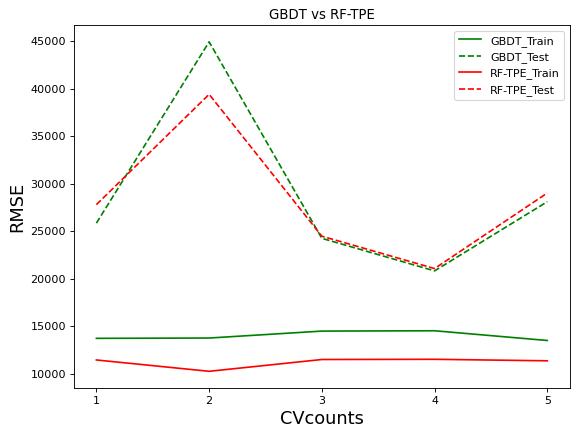

In [103]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[:5:3],models[:5:3],colors[:5:3]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("GBDT vs RF-TPE")
plt.legend()
plt.show()

不难发现，GBDT的过拟合程度是轻于优化后的随机森林的。并且，在大部分交叉验证的结果下，GBDT的效果都接近或好于优化后的随机森林。在cv=2时GBDT的表现远不如森林，一次糟糕的表现拉低了GBDT的整体表现，否则GBDT可能在默认参数上表现出比优化后的随机森林更好的结果。如果我们可以通过调参优化让GBDT的表现更加稳定，GBDT可能会出现惊人的表现。

- 梯度提升树分类

In [70]:
#分类数据
X_clf = data.iloc[:,:-2]
y_clf = data.iloc[:,-2]

In [71]:
np.unique(y_clf) #6分类

array([0., 1., 2., 3., 4., 5.])

In [72]:
#GBDT分类的实现
clf = GBC(random_state=1412) #实例化
cv = KFold(n_splits=5,shuffle=True,random_state=1412)
result_clf = cross_validate(clf,X_clf,y_clf,cv=cv
                            ,return_train_score=True
                            ,verbose=True
                            ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


In [73]:
result_clf

{'fit_time': array([3.47425294, 3.40723777, 3.38023067, 3.39023256, 3.41823983]),
 'score_time': array([0.0040009 , 0.00400043, 0.00400066, 0.00300074, 0.00400186]),
 'test_score': array([0.89726027, 0.8869863 , 0.90410959, 0.8869863 , 0.90753425]),
 'train_score': array([0.99058219, 0.99315068, 0.99229452, 0.99143836, 0.99143836])}

In [120]:
result_clf["train_score"].mean()

0.9919520547945206

In [121]:
result_clf["test_score"].mean()

0.8979452054794521

# 二 梯度提升树的参数

*class* `sklearn.ensemble.GradientBoostingClassifier`(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

*class* `sklearn.ensemble.GradientBoostingRegressor`(*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

与随机森林一样，由于GBDT超参数数量较多，因此我们可以将GBDT的参数分为以下5大类别，其中标注为绿色的参数包括了我们未曾学过的知识、需要重点讲解：

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：n_estimators, learning_rate, **<font color="green">loss, alpha, init</font>**<br>属性：<font color="green">**loss_, init_, estimators_**</font>|
|**弱评估器结构**|<font color="green">**criterion**</font>, max_depth, min_samples_split, min_samples_leaf, <br>min_weight_fraction_leaf, max_leaf_nodes,<br>min_impurity_decrease|
|**提前停止**|参数：<font color="green">**validation_fraction, n_iter_no_change, tol**</font><br>属性：<font color="green">**n_estimators_**</font>|
|**弱评估器的训练数据**|参数：subsample, max_features, random_state<br>属性：<font color="green">**oob_improvement, train_score_**</font>|
|**其他**|ccp_alpha, warm_start|

## 1 迭代过程

之前我们提到过，GBDT的整体建模流程与AdaBoost高度相似，因此GBDT当中也有设置具体迭代次数（弱评估器次数）的参数`n_estimators`与学习率参数`learning_rate`，这两个参数的含义、以及对集成算法的影响与AdaBoost当中完全一致。

具体地来说，对于样本$x_i$，集成算法当中一共有$T$棵树，则参数`n_estimators`的取值为T。假设现在正在建立第$t$个弱评估器，则则第$t$个弱评估器上$x_i$的结果可以表示为$f_t(x_i)$。假设整个Boosting算法对样本$x_i$输出的结果为$H(x_i)$，则该结果一般可以被表示为t=1~t=T过程当中，所有弱评估器结果的加权求和：

$$H(x_i) =  \sum_{t=1}^\boldsymbol{\color{red}T}\phi_tf_t(x_i)$$

其中，$\phi_t$为第t棵树的权重。对于第$t$次迭代来说，则有：

$$H_t(x_i) = H_{t-1}(x_i) + \phi_tf_t(x_i)$$

在这个一般过程中，每次将本轮建好的决策树加入之前的建树结果时，可以在权重$\phi$前面增加参数$\color{red}\eta$，表示为第t棵树加入整体集成算法时的学习率，对标参数`learning_rate`。

$$H_t(x_i) = H_{t-1}(x_i) + \boldsymbol{\color{red}\eta} \phi_tf_t(x_i)$$

该学习率参数控制Boosting集成过程中$H(x_i)$的增长速度，是相当关键的参数。当学习率很大时，$H(x_i)$增长得更快，我们所需的`n_estimators`更少，当学习率较小时，$H(x_i)$增长较慢，我们所需的`n_estimators`就更多，因此boosting算法往往会需要在`n_estimators`与`learning_rate`中做出权衡。

这两个参数的使用方法与AdaBoost中也完全一致，故此处不再赘述，后续我们会直接使用这两个参数进行调参。

### 1.1 初始预测结果$H_0$的设置

在上述过程中，我们建立第一个弱评估器时有：

$$H_1(x_i) = H_{0}(x_i) + \phi_1f_1(x_i)$$

由于没有第0棵树的存在，因此$H_0(x_i)$的值在数学过程及算法具体实现过程中都需要进行单独的确定，这一确定过程由参数`init`确定。

- 参数`init`：输入计算初始预测结果$H_0$的估计器对象。

在该参数中，可以输入任意评估器、字符串"zero"、或者None对象，默认为None对象。
> 当输入任意评估器时，评估器必须要具备fit以及predict_proba功能，即我们可以使用决策树、逻辑回归等可以输出概率的模型。如果输出一个已经训练过、且精细化调参后的模型，将会给GBDT树打下坚实的基础。<br><br>
> 填写为字符串"zero"，则代表令$H_0 = 0$来开始迭代。<br><br>
> 不填写，或填写为None对象，sklearn则会自动选择类`DummyEstimator`中的某种默认方式进行预测作为$H_0$的结果。`DummyEstimator`类是sklearn中设置的使用超简单规则进行预测的类，其中最常见的规则是直接从训练集标签中随机抽样出结果作为预测标签，也有选择众数作为预测标签等选项。

一般在GBDT类的使用过程中，我们不会主动调节参数`init`，但是当我们有足够的算力支持超参数搜索时，我们可以在`init`上进行选择。

In [104]:
from sklearn.tree import DecisionTreeRegressor as DTR

In [106]:
tree_reg = DTR(random_state=1412)
rf = RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0
              ,random_state=1412, verbose=False, n_jobs=-1)

In [107]:
for init in [tree_reg,rf,"zero",None]:
    reg = GBR(init = init,random_state=1412)
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    result_reg = cross_validate(reg,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                                ,return_train_score=True
                                ,verbose=False
                                ,n_jobs=-1)
    print("\n")
    print(RMSE(result_reg,"train_score"))
    print(RMSE(result_reg,"test_score"))



0.0
42065.93924112058


5669.291478825804
27171.244181270857


13990.791639702458
28739.882050269225


13990.790813889864
28783.954343252786


不难发现，初始参数的具体输入会对模型的最终结果造成巨大影响，在init中输入训练好的模型会加重GBDT的过拟合，但同时也可能得到更好的测试集结果。我们甚至可以无限套娃，让init参数中输入被训练好的GBDT模型，当然，这样做的结果往往是过拟合被放大到无法挽回了。通常来说，我们还是会选择"zero"作为init的输入。

与参数`init`相对的属性就是`init_`，当模型被拟合完毕之后，我们可以使用该属性来返回输出$H_0$的评估器对象。

In [109]:
reg = GBR(init = None,random_state=1412)
reg.fit(X,y).init_ #返回sklearn中的玩具评估器DummyRegressor

DummyRegressor()

In [110]:
reg = GBR(init = rf,random_state=1412)
reg.fit(X,y).init_

RandomForestRegressor(max_depth=22, max_features=14, min_impurity_decrease=0,
                      n_estimators=89, n_jobs=-1, random_state=1412,
                      verbose=False)

当然，在init中的值是我们自己输入的值的情况下，属性`init_`略显鸡肋，但我们或许会预见需要该属性的具体场景，例如在建模过程中进行监控打印时、或在大量初始化模型中选择最佳初始化模型时。

### 【完整版】 1.2 使用回归器完成分类任务

### 1.3 GBDT的8种损失函数

作为基于AdaBoost改进的Boosting算法，GBDT的功绩之一是将损失函数从有限的指数损失、MSE等推广到了任意可微函数，因此GBDT的损失函数选择异常丰富，因此我们可以在调参时加入损失函数作为需要调整的参数进行考量。在sklearn中，控制具体损失函数的参数为`loss`。

GBDT中的损失函数因GBDT具体执行的预测任务而存在区别，同时也因标签的分布而存在区别。对于梯度提升分类树来说，loss的备选项有如下几种：

- 分类器中的`loss`：字符串型，可输入"deviance", "exponential"，默认值="deviance"

其中"deviance"直译为偏差，特指逻辑回归的损失函数——交叉熵损失，而"exponential"则特指AdaBoost中使用的指数损失函数。对任意样本$i$而言，$y_i$为真实标签，$\hat{y_i}$为预测标签，$H(x_i)$为集成算法输出结果，$p(x_i)$为基于$H(x_i)$和sigmoid/softmax函数计算的概率值。则各个损失的表达式为：

**二分类交叉熵损失**——<br><br>
$$L = -\left( y\log p(x) + (1 - y)\log(1 - p(x)) \right)$$

<br>注意，log当中输入的一定是概率值。对于逻辑回归来说，概率就是算法的输出，因此我们可以认为逻辑回归中$p = H(x)$，但对于GBDT来说，$p(x_i) = Sigmoid(H(x_i))$，这一点一定要注意。

<br>

**多分类交叉熵损失**，总共有K个类别——<br><br>

$$L = -\sum_{k=1}^Ky^*_k\log(P^k(x))$$

其中，$P^k(x)$是概率值，对于多分类GBDT来说，$p^k(x) = Softmax(H^k(x))$。$y^*$是由真实标签转化后的向量。例如，在3分类情况下，真实标签$y_i$为2时，$y^*$为[$y^*_{1}$,$y^*_{2}$,$y^*_{3}$]，取值分别为：

|$y^*_{1}$|$y^*_{2}$|$y^*_{3}$|
|:-:|:-:|:-:|
|$0$|$1$|$0$|

这一转化过程与AdaBoost中多分类指数损失中的转化高度相似。

**二分类指数损失**——<br><br>
$$L = e^{-yH(x)}$$<br>

**多分类指数损失**，总共有K个类别——<br><br>

$$
\begin{aligned}
L &=exp \left( -\frac{1}{K}\boldsymbol{y^* · H^*(x)} \right) \\ 
& = exp \left( -\frac{1}{K}(y^1H^1(x)+y^2H^2(x) \ + \  ... + y^kH^k(x)) \right)
\end{aligned}
$$<br>

需要注意，指数损失中的$y^*$与交叉熵损失中的$y^*$不是同样的向量。我们已经在逻辑回归的章节中详解过交叉熵损失，在AdaBoost的章节当中详解过指数损失，因此这里便不再展开赘述了。需要注意的是，一般梯度提升分类器默认使用交叉熵损失，如果使用指数损失，则相当于执行没有权重调整的AdaBoost算法。

对于梯度提升回归树来说，loss的备选项有如下几种：

- 回归器中的`loss`：字符串型，可输入{"squared_error", "absolute_error", "huber", "quantile"}，默认值="squared_error"

其中'squared_error'是指回归的平方误差，'absolute_error'指的是回归的绝对误差，这是一个鲁棒的损失函数。'huber'是以上两者的结合。'quantile'则表示使用分位数回归中的弹球损失pinball_loss。对任意样本$i$而言，$y_i$为真实标签，$H(x_i)$为预测标签，则各个损失的表达式为：

**平方误差**——<br><br>

$$L = \sum{(y_i - H(x_i))^2}$$

<center>（也可写作$\frac{1}{2}\sum{(y_i - H(x_i))^2}$以方便计算）
</center><br>

**绝对误差**——<br><br>

$$L = \sum{|y_i - H(x_i)|}$$

<br>

**Huber损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}\frac{1}{2}(y_i - H(x_i))^2, & |y_i - H(x_i)|\leq\alpha \\
\alpha(|y_i - H(x_i)|-\frac{\alpha}{2}),& |y_i - H(x_i)|>\alpha \end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

<br>

**quantile损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}
    \alpha (y_i - H(x_i)), & y_i - H(x_i) > 0 \\
    0,    & y_i - H(x_i) = 0 \\
    (1-\alpha) (y_i - H(x_i)), & y_i - H(x_i) < 0
\end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

其中$\alpha$是需要我们自己设置的超参数，由参数`alpha`控制。在huber损失中，alpha是阈值，在quantile损失中，alpha用于辅助计算损失函数的输出结果，默认为0.9。

**<font color=red>===更新警告===</font>**<br>
在sklearn1.0版本及后续版本当中，损失函数"ls"与"lad"被删除了，其中"ls"的功能被"squared_error"取代，而"lad"被"absolute_error"取代。如果你在运行代码时，发现你的参数默认值、参数名称与课件中不相同，或者在运行过程中出现报错、警告等现象，你可能需要更新你的sklearn。

In [ ]:
对于相同的样本、相同的差异，不同损失函数给出的损失值不同

In [ ]:
yi = 10
Hx = 8

In [ ]:
绝对 - 2
平方 - 4 - 差异>1，误差被放大，差异<1，误差是会被缩小

- 如何选择不同的损失函数？

GBDT是工业应用最广泛的模型，工业数据大部分都极度偏态、具有长尾，因此GBDT必须考虑**离群值**带来的影响。数据中的离群值会极大程度地影响模型地构建，当离群值在标签当中、而我们是依赖于减小损失函数来逐渐构建算法时，这种影响会前所未有地大。**因此Boosting是天生更容易被离群值影响的模型、也更擅长学习离群值的模型。**<br><br>
![](https://discourse-cloud-file-uploads.s3.dualstack.us-west-2.amazonaws.com/business6/uploads/analyticsvidhya/original/1X/c3af040fef3ddc8f2bb1b393d71700e9a638426e.PNG)
![](https://discourse-cloud-file-uploads.s3.dualstack.us-west-2.amazonaws.com/business6/uploads/analyticsvidhya/original/1X/f3c5885defae011dd385462f1f3812ff24393105.PNG)

举例来说，若离群值的标签为1000，大部分正常样本的标签在0.1~0.2之间，算法一定会异常努力地学习离群值的规律，因为将离群值预测错误会带来巨大的损失。在这种状况下，最终迭代出的算法可能是严重偏离大部分数据的规律的。同样，我们也会遇见很多离群值对我们很关键的业务场景：例如，电商中的金额离群用户可能是VIP用户，风控中信用分离群的用户可能是高风险用户，这种状况下我们反而更关注将离群值预测正确。不同的损失函数可以帮助我们解决不同的问题——

- **当高度关注离群值、并且希望努力将离群值预测正确时，选择平方误差**<br><br>
这在工业中是大部分的情况。在实际进行预测时，离群值往往比较难以预测，因此离群样本的预测值和真实值之间的差异一般会较大。MSE作为预测值和真实值差值的平方，会放大离群值的影响，会让算法更加向学习离群值的方向进化，这可以帮助算法更好地预测离群值。

- **努力排除离群值的影响、更关注非离群值的时候，选择绝对误差**<br><br>
MAE对一切样本都一视同仁，对所有的差异都只求绝对值，因此会保留样本差异最原始的状态。相比其MSE，MAE对离群值完全不敏感，这可以有效地降低GBDT在离群值上的注意力。

- **试图平衡离群值与非离群值、没有偏好时，选择Huber或者Quantileloss**<br><br>
Huberloss损失结合了MSE与MAE，在Huber的公式中，当预测值与真实值的差异大于阈值时，则取绝对值，小于阈值时，则取平方。在真实数据中，部分离群值的差异会大于阈值，部分离群值的差异会小于阈值，因此比起全部取绝对值的MAE，Huberloss会将部分离群值的真实预测差异求平方，相当于放大了离群值的影响（但这种影响又不像在MSE那样大）。因此HuberLoss是位于MSE和MAE之间的、对离群值相对不敏感的损失。

- 属性`loss_`

In [134]:
reg = GBR(n_estimators=10,random_state=1412).fit(X,y)

In [135]:
reg.loss_ #返回具体的损失函数对象，而不会返回公式

总结一下，在整个迭代过程中，我们涉及到了如下参数及属性：

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：<br><br>&emsp;n_estimators：集成算法中弱分类器数量，对Boosting算法而言为实际迭代次数<br><br>&emsp;learning_rate：Boosting算法中的学习率，影响弱分类器结果的加权求和过程<br><br>&emsp;<font color="green">**loss, alpha**</font>：需要优化的损失函数，以及特定损失函数需要调节的阈值<br><br>&emsp;<font color="green">**init**</font>：初始化预测结果$H_0$的设置<br><br>属性：<br><br>&emsp;<font color="green">**loss_**</font>：返回具体的损失函数对象<br><br>&emsp;<font color="green">**init_**</font>：返回具体的初始化设置<br><br>&emsp;<font color="green">**estimators_**</font>：返回实际建立的评估器列表<br><br>&emsp;n_estimators_：返回实际迭代次数|

##  【完整版】 2 弱评估器结构

### 【完整版】2.1 梯度提升树中的弱评估器复杂度

### 【完整版】2.2 弗里德曼均方误差

## 【完整版】3 梯度提升树的提前停止

## 【完整版】4 梯度提升树的袋外数据

## 【完整版】5 缺失的class_weight与n_jobs

# 三 GBDT的参数空间与超参数优化

## 1 确定GBDT优化的参数空间

丰富的超参数为集成算法提供了无限的可能，以降低偏差为目的的Boosting算法们在调参之后的表现更是所向披靡，因此GBDT的超参数自动优化也是一个重要的课题。对任意集成算法进行超参数优化之前，我们需要明确两个基本事实：

1、不同参数对算法结果的影响力大小<br>
2、确定用于搜索的参数空间<br>

对GBDT来说，我们可以大致如下排列各个参数对算法的影响：

|影响力|参数|
|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|n_estimators（整体学习能力）<br>learning_rate（整体学习速率）<br>max_features（随机性）<br>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|init（初始化）<br>subsamples（随机性）<br>loss（整体学习能力）|
|⭐⭐<br>可能有大影响力<br>大部分时候影响力不明显|max_depth（粗剪枝）<br>min_samples_split（精剪枝）<br>min_impurity_decrease（精剪枝）<br>max_leaf_nodes（精剪枝）<br>criterion（分枝敏感度）|
|⭐<br>当数据量足够大时，几乎无影响|random_state<br>ccp_alpha（结构风险）|

如果你熟悉随机森林的超参数，你会发现GBDT中大部分超参数的影响力等级都非常容易理解。树的集成模型们大多拥有相似的超参数，例如抗过拟合、用来剪枝的参数群（`max_depth`、`min_samples_split`等），又比如对样本/特征进行抽样的参数们（`subsample`，`max_features`等），这些超参数在不同的集成模型中以相似的方式影响模型，因此原则上来说，对随机森林影响较大的参数对GBDT也会有较大的影响。

然而你可能注意到，在随机森林中非常关键的`max_depth`在GBDT中没有什么地位，取而代之的是Boosting中特有的迭代参数学习率`learning_rate`。在随机森林中，我们总是在意模型复杂度(`max_depth`)与模型整体学习能力(`n_estimators`)的平衡，单一弱评估器的复杂度越大，单一弱评估器对模型的整体贡献就越大，因此需要的树数量就越少。在Boosting算法当中，单一弱评估器对整体算法的贡献由学习率参数`learning_rate`控制，代替了弱评估器复杂度的地位，因此Boosting算法中我们寻找的是`learning_rate`与`n_estimators`的平衡。同时，Boosting算法天生就假设单一弱评估器的能力很弱，参数`max_depth`的默认值也往往较小（在GBDT中`max_depth`的默认值是3），因此我们无法靠降低`max_depth`的值来大规模降低模型复杂度，更难以靠`max_depth`来控制过拟合，自然`max_depth`的影响力就变小了。

可见，虽然树的集成算法们大多共享相同的超参数，都由于不同算法构建时的原理假设不同，**相同参数在不同算法中的默认值可能被设置得不同，因此相同参数在不同算法中的重要性和调参思路也不同**。

在讲解随机森林时我们提到过，精剪枝工具的效用有限，剪枝一般还是大刀阔斧的粗剪枝更有效。在GBDT中，由于`max_depth`这一粗剪枝工具的默认值为3，因此在Boosting算法中通过削减模型复杂度来控制过拟合的思路就无法走通。特别地，参数`init`对GBDT的影响很大，如果在参数`init`中填入具体的算法，过拟合可能会变得更加严重，因此我们需要在抑制过拟合、控制复杂度这一点上令下功夫。

如果无法对弱评估器进行剪枝，最好的控制过拟合的方法就是增加随机性/多样性，因此`max_features`和`subsample`就成为Boosting算法中控制过拟合的核心武器，这也是GBDT中会加入Bagging思想的关键原因之一。依赖于随机性、而非弱评估器结构来对抗过拟合的特点，让Boosting算法获得了一个意外的优势：比起Bagging，Boosting更加擅长处理小样本高维度的数据，因为Bagging数据很容易在小样本数据集上过拟合。

需要注意的是，虽然`max_depth`在控制过拟合上的贡献不大，但是我们在调参时依然需要保留这个参数。当我们使用参数`max_features`与`subsample`构建随机性、并加大每一棵树之间的差异后，模型的学习能力可能受到影响，因此我们可能需要提升单一弱评估器的复杂度。因此在GBDT当中，`max_depth`的调参方向是放大/加深，以探究模型是否需要更高的单一评估器复杂度。相对的在随机森林当中，`max_depth`的调参方向是缩小/剪枝，用以缓解过拟合。

那在调参的时候，我们应该选择哪些参数呢？与随机森林一样，我们首先会考虑所有影响力巨大的参数（5星参数），当算力足够/优化算法运行较快的时候，我们可以考虑将大部分时候具有影响力的参数（4星）也都加入参数空间，如果样本量较小，我们可能不选择`subsample`。除此之外，我们还需要部分影响弱评估器复杂度的参数，例如`max_depth`。如果算力充足，我们还可以加入`criterion`这样或许会有效的参数。在这样的基本思想下，考虑到硬件与运行时间因素，我将选择如下参数进行调整，并使用基于TPE贝叶斯优化（HyperOpt）对GBDT进行优化——

|参数|
|:-:|
|`loss`|
|`criterion`|
|`init`|
|`n_estimators`|
|`learning_rate`|
|`max_features`|
|`subsamples`|
|`max_depth`|
|`min_impurity_decrease`|

在此基础上，我们需要进一步确认参数空间。幸运的是，GBDT的参数空间几乎不依赖于树的真实结构进行调整，且大部分参数都有固定的范围，因此我们只需要对无界的参数稍稍探索即可。

其中，我们在《二 4 袋外数据》部分已经对`n_estimators`进行过探索（如果你没有经过这个探索，则需要绘制绘制学习曲线进行探索），在当前默认参数下，我们大约只需要50次迭代就能够让损失函数收敛，因此我们可以就50这个数字向两侧展开来设置`n_estimators`的搜索范围。

另外，原则上来说需要用Tree对象来探索`min_impurity_decrease`的值，但由于我们这个参数只能放大、不能缩小，且我们知道精剪枝对于GBDT的影响较小，因此就不必大费周章地给与该参数一个精细的范围了，按照(0,C)结构走即可，其中C为任意常数。

具体每个参数的初始范围确定如下：

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

一般在初次搜索时，我们会设置范围较大、较为稀疏的参数空间，然后在多次搜索中逐渐缩小范围、降低参数空间的维度。需要注意的是，`init`参数中需要输入的评估器对象无法被HyperOpt库识别，因此参数`init`我们只能手动调参。在之前的课程《二 1.1 初始预测结果H0的设置》中，我们已经对`init`尝试过三种参数，分别是精调后的模型rf，字符串"zero"与"None"，并且我们已经看到rf给出的结果是最好的，因此我们就按照`init`= rf来设置参数，不再对该参数进行调整。

## 2 基于TPE对GBDT进行优化

In [19]:
#日常使用库与算法
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_validate, KFold

#导入优化算法
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [2]:
data = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\train_encode.csv",index_col=0)

In [3]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [4]:
X.shape

(1460, 80)

> Step 1.建立benchmark

|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|1.29s|0.28s|0.49s|0.22s|0.27s|
|最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|

> Step 2.定义参数`init`需要的算法

In [5]:
rf = RFR(n_estimators=89, max_depth=22, max_features=14,min_impurity_decrease=0
         ,random_state=1412, verbose=False, n_jobs=-1)

> Step 3.定义目标函数、参数空间、优化函数、验证函数
>> 目标函数

In [6]:
def hyperopt_objective(params):
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["lr"]
              ,criterion = params["criterion"]
              ,loss = params["loss"]
              ,max_depth = int(params["max_depth"])
              ,max_features = params["max_features"]
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,init = rf
              ,random_state=1412
              ,verbose=False)
    
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                     ,error_score='raise'
                                    )
    return np.mean(abs(validation_loss["test_score"]))

>> 参数空间

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

In [51]:
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",25,200,25)
                  ,"lr": hp.quniform("learning_rate",0.05,2.05,0.05)
                  ,"criterion": hp.choice("criterion",["friedman_mse", "squared_error", "mse", "mae"])
                  ,"loss":hp.choice("loss",["squared_error","absolute_error", "huber", "quantile"])
                  ,"max_depth": hp.quniform("max_depth",2,30,2)
                  ,"subsample": hp.quniform("subsample",0.1,0.8,0.1)
                  ,"max_features": hp.choice("max_features",["log2","sqrt",16,32,64,"auto"])
                  ,"min_impurity_decrease":hp.quniform("min_impurity_decrease",0,5,1)
                 }

>> 计算参数空间大小：

In [52]:
len(range(25,200,25)) * len(np.arange(0.05,2.05,0.05)) * 4 * 4 * len(range(2,30,2)) * len(np.arange(0.1,0.8,0.1)) * 6 * len(range(0,5,1))

13171200

虽然参数分布较为稀疏，但由于参数维度众多、范围较大，因此这是一个超大的参数空间。

>> 优化函数

In [7]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(100)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

>> 验证函数（可选）

In [8]:
def hyperopt_validation(params):    
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["learning_rate"]
              ,criterion = params["criterion"]
              ,loss = params["loss"]
              ,max_depth = int(params["max_depth"])
              ,max_features = params["max_features"]
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,init = rf
              ,random_state=1412 #GBR中的random_state只能够控制特征抽样，不能控制样本抽样
              ,verbose=False)
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                    )
    return np.mean(abs(validation_loss["test_score"]))

> Step 4.训练贝叶斯优化器

In [59]:
params_best, trials = param_hyperopt(30) #使用小于0.1%的空间进行训练

100%|████████████████████████████████████████████████| 30/30 [00:45<00:00,  1.51s/trial, best loss: 26888.311566837725]

 
 best params:  {'criterion': 2, 'learning_rate': 0.2, 'loss': 0, 'max_depth': 24.0, 'max_features': 0, 'min_impurity_decrease': 5.0, 'n_estimators': 175.0, 'subsample': 0.7000000000000001} 



In [60]:
params_best #注意hp.choice返回的结果是索引，而不是具体的数字

{'criterion': 2,
 'learning_rate': 0.2,
 'loss': 0,
 'max_depth': 24.0,
 'max_features': 0,
 'min_impurity_decrease': 5.0,
 'n_estimators': 175.0,
 'subsample': 0.7000000000000001}

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

In [63]:
hyperopt_validation({'criterion': "mse",
                     'learning_rate': 0.2,
                     'loss': "squared_error",
                     'max_depth': 24.0,
                     'max_features': "log2",
                     'min_impurity_decrease': 5.0,
                     'n_estimators': 175.0,
                     'subsample': 0.7})

26888.311566837725

不难发现，我们已经得到了历史最好分数，但GBDT的潜力远不止如此。现在我们可以根据第一次训练出的结果缩小参数空间，继续进行搜索。在多次搜索中，我发现`loss`参数的最优选项基本都是平方误差"squared_error"，因此我们可以将该参数排除出搜索队伍。同样，对于其他参数，我们则根据搜索结果**修改空间范围、增加空间密度**，一般以被选中的值为中心向两边拓展，并减小步长，同时范围可以向我们认为会被选中的一边倾斜。例如最大深度`max_depth`被选为24，我们则将原本的范围(2,30,2)修改为(10,35,1)。同样`subsample`被选为0.7，我们则将新范围调整为(0.5,1.0,0.05)，依次类推。

In [17]:
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",150,200,5)
                     ,"lr": hp.quniform("learning_rate",0.05,3,0.05)
                     ,"criterion": hp.choice("criterion",["friedman_mse", "squared_error", "mse","mae"])
                     ,"max_depth": hp.quniform("max_depth",10,35,1)
                     ,"subsample": hp.quniform("subsample",0.5,1,0.05)
                     ,"max_features": hp.quniform("max_features",10,30,1)
                     ,"min_impurity_decrease":hp.quniform("min_impurity_decrease",0,5,0.5)
                    }

由于需要修改参数空间，因此目标函数也必须跟着修改：

In [15]:
def hyperopt_objective(params):
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["lr"]
              ,criterion = params["criterion"]
              ,max_depth = int(params["max_depth"])
              ,max_features = int(params["max_features"])
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,loss = "squared_error"
              ,init = rf
              ,random_state=1412
              ,verbose=False)
    
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                     ,error_score='raise'
                                    )
    return np.mean(abs(validation_loss["test_score"]))

In [17]:
params_best, trials = param_hyperopt(30) #使用小于0.1%的空间进行训练

100%|████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42trial/s, best loss: 26705.080632614565]

 
 best params:  {'criterion': 2, 'learning_rate': 0.28, 'max_depth': 16.0, 'max_features': 16.0, 'min_impurity_decrease': 3.5, 'n_estimators': 185.0, 'subsample': 0.8500000000000001} 



In [18]:
params_best, trials = param_hyperopt(100) #尝试增加搜索次数

100%|███████████████████████████████████████████████| 100/100 [05:09<00:00,  3.09s/trial, best loss: 26519.12578332204]

 
 best params:  {'criterion': 2, 'learning_rate': 0.1, 'max_depth': 12.0, 'max_features': 19.0, 'min_impurity_decrease': 0.0, 'n_estimators': 195.0, 'subsample': 0.55} 



基于该结果，我们又可以确定进一步确定部分参数的值（比如criterion），再次缩小参数范围、增加参数空间的密集程度：

In [19]:
def hyperopt_objective(params):
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["lr"]
              ,max_depth = int(params["max_depth"])
              ,max_features = int(params["max_features"])
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,criterion = "mse"
              ,loss = "squared_error"
              ,init = rf
              ,random_state=1412
              ,verbose=False)
    
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                     ,error_score='raise'
                                    )
    return np.mean(abs(validation_loss["test_score"]))

In [21]:
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",175,200,1)
                     ,"lr": hp.quniform("learning_rate",0.1,0.3,0.005)
                     ,"max_depth": hp.quniform("max_depth",8,22,1)
                     ,"subsample": hp.quniform("subsample",0.5,1,0.0025)
                     ,"max_features": hp.quniform("max_features",10,20,1)
                     ,"min_impurity_decrease":hp.quniform("min_impurity_decrease",1,4,0.25)
                    }

In [29]:
params_best, trials = param_hyperopt(300) #缩小参数空间的同时增加迭代次数

 57%|██████████████████████████▉                    | 172/300 [01:46<01:19,  1.62trial/s, best loss: 26501.91471740881]

 
 best params:  {'learning_rate': 0.115, 'max_depth': 8.0, 'max_features': 12.0, 'min_impurity_decrease': 2.5, 'n_estimators': 183.0, 'subsample': 1.0} 



In [ ]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    #early_stop_fn = no_progress_loss(100)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       #, early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [32]:
params_best, trials = param_hyperopt(300) #取消提前停止，继续迭代

100%|██████████████████████████████████████████████| 300/300 [03:02<00:00,  1.64trial/s, best loss: 26448.278731971972]

 
 best params:  {'learning_rate': 0.25, 'max_depth': 9.0, 'max_features': 15.0, 'min_impurity_decrease': 3.25, 'n_estimators': 176.0, 'subsample': 1.0} 



In [33]:
params_best, trials = param_hyperopt(1000)

100%|████████████████████████████████████████████| 1000/1000 [12:07<00:00,  1.38trial/s, best loss: 26415.835015071534]

 
 best params:  {'learning_rate': 0.21, 'max_depth': 8.0, 'max_features': 13.0, 'min_impurity_decrease': 3.5, 'n_estimators': 187.0, 'subsample': 0.8675} 



In [30]:
start = time.time()
hyperopt_validation({'criterion': "mse",
                     'learning_rate': 0.21,
                     'loss': "squared_error",
                     'max_depth': 8.0,
                     'max_features': 13,
                     'min_impurity_decrease': 3.5,
                     'n_estimators': 187.0,
                     'subsample': 0.8675})

26415.835015071538

In [31]:
end = (time.time() - start)
print(end)

1.5381402969360352


|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|1.29s|0.28s|0.49s|0.22s|0.27s|<font color="brown">**1.54s(↑)**</font>|
|最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|<font color="green">**26415.835(↓)**</font>|

GBDT获得了目前为止的最高分，虽然这一组参数最终指向了187棵树，导致GBDT运行所需的时间远远高于其他算法，GBDT上得到的分数是比精细调参后的随机森林还低2000左右，这证明了GBDT在学习能力上的优越性。由于TPE是带有强随机性的过程，因此如果我们多次运行，我们将得到不同的结果，但GBDT的预测分数可以稳定在26500上下。如果算力支持使用更多的迭代次数、或使用更大更密集的参数空间，我们或许可以得到更好的分数。同时，如果我们能够找到一组大学习率、小迭代次数的参数，那GBDT的训练速度也会随之上升。你可以试着在最初的范围中寻找另一个突破口，尝试将GBDT的速度降低。

# 【完整版】四 原理进阶：GBDT的求解流程
## 【完整版】1 GBDT的基本数学流程
## 【完整版】2 初始化$H_0$过程中的常数C是什么？
## 【完整版】3 伪残差与残差、梯度有什么关系？
## 【完整版】4 证明：拟合伪残差可以令损失函数最快地减小